# Detecting Flu Epidemics via Search Engine Query Data 
Flu epidemics constitute a major public health concern causing respiratory illnesses, hospitalizations, and deaths. According to the National Vital Statistics Reports published in October 2012, influenza ranked as the eighth leading cause of death in 2011 in the United States. Each year, 250,000 to 500,000 deaths are attributed to influenza related diseases throughout the world.

The U.S. Centers for Disease Control and Prevention (CDC) and the European Influenza Surveillance Scheme (EISS) detect influenza activity through virologic and clinical data, including Influenza-like Illness (ILI) physician visits. Reporting national and regional data, however, are published with a 1-2 week lag.

The csv file FluTrain (CSV) aggregates this data from January 1, 2004 until December 31, 2011 as follows:

"Week" - The range of dates represented by this observation, in year/month/day format.

"ILI" - This column lists the percentage of ILI-related physician visits for the corresponding week.

"Queries" - This column lists the fraction of queries that are ILI-related for the corresponding week, adjusted to be between 0 and 1 (higher values correspond to more ILI-related search queries).

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.preprocessing import OrdinalEncoder
from sklearn import metrics
from scipy import stats
import seaborn as sns
import math
%matplotlib inline

Before applying analytics tools on the training set, we first need to understand the data at hand. We load "FluTrain.csv" into a data frame called FluTrain. Looking at the time period 2004-2011, we try to find which week corresponds to the highest percentage of ILI-related physician visits. We select the day of the month corresponding to the start of this week.

In [3]:
Flu_Train= pd.read_csv('FluTrain.csv')

In [4]:
Flu_Train.head()

,Week,ILI,Queries
0,2004-01-04 - 2004-01-10,2.418331,0.237716
1,2004-01-11 - 2004-01-17,1.809056,0.220452
2,2004-01-18 - 2004-01-24,1.712024,0.225764
3,2004-01-25 - 2004-01-31,1.542495,0.237716
4,2004-02-01 - 2004-02-07,1.437868,0.224436


In [5]:
Flu_Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417 entries, 0 to 416
Data columns (total 3 columns):
Week       417 non-null object
ILI        417 non-null float64
Queries    417 non-null float64
dtypes: float64(2), object(1)
memory usage: 9.9+ KB


In [6]:
Flu_Train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ILI,417.0,1.676861,1.126163,0.534093,0.902459,1.252563,2.058690,7.618892
Queries,417.0,0.286028,0.157697,0.041169,0.156707,0.281541,0.378486,1.000000


In [7]:
Flu_Train["Queries"].max()

1.0

In [8]:
MaxQuery = Flu_Train[Flu_Train["Queries"] == 1]

In [9]:
MaxQuery

,Week,ILI,Queries
302,2009-10-18 - 2009-10-24,7.618892,1.0


# Understanding the Data
Let us now understand the data at an aggregate level. For this we plot the histogram of the dependent variable, ILI. Most of the ILI values are small, with a relatively small number of much larger values skew right.

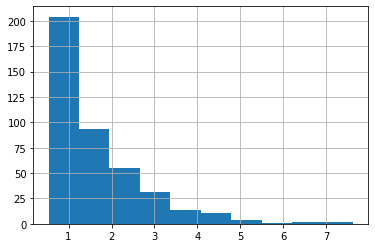

In [10]:
Flu_Train["ILI"].hist()

When handling a skewed dependent variable, it is often useful to predict the logarithm of the dependent variable instead of the dependent variable itself -- this prevents the small number of unusually large or small observations from having an undue influence on the sum of squared errors of predictive models. In this exercise, we will predict the natural log of the ILI variable, which can be computed using the log() function.

In [11]:
LogILI = np.log(Flu_Train["ILI"])

In [12]:
LogILI.head()

0    0.883078
1    0.592805
2    0.537676
3    0.433401
4    0.363162
Name: ILI, dtype: float64

We plot the natural logarithm of ILI versus Queries.We detect a positive, linear relationship between log(ILI) and Queries.

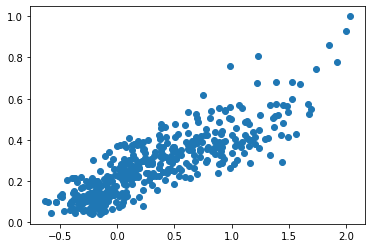

In [13]:
plt.scatter(LogILI, Flu_Train["Queries"])

In order to prepare the data to build a model, we replace the dependent variable with its log values and we interchange the dependent and independent variable columns.

In [14]:
Flu_Train["ILI"] = LogILI

In [15]:
Flu_Train.head()

,Week,ILI,Queries
0,2004-01-04 - 2004-01-10,0.883078,0.237716
1,2004-01-11 - 2004-01-17,0.592805,0.220452
2,2004-01-18 - 2004-01-24,0.537676,0.225764
3,2004-01-25 - 2004-01-31,0.433401,0.237716
4,2004-02-01 - 2004-02-07,0.363162,0.224436


In [16]:
Flu_Train.tail()

,Week,ILI,Queries
412,2011-11-27 - 2011-12-03,0.382349,0.478088
413,2011-12-04 - 2011-12-10,0.417464,0.464807
414,2011-12-11 - 2011-12-17,0.509197,0.479416
415,2011-12-18 - 2011-12-24,0.616663,0.537849
416,2011-12-25 - 2011-12-31,0.753362,0.618858


In [18]:
Flu_Train_Subset = Flu_Train[['Queries','ILI']]

In [20]:
Flu_Train_Subset.head()

,Queries,ILI
0,0.237716,0.883078
1,0.220452,0.592805
2,0.225764,0.537676
3,0.237716,0.433401
4,0.224436,0.363162


# Linear Regression Model
Based on the plot we made above, it seems that a linear regression model could be a good modeling choice. Based on our understanding of the data from the previous exercise, log(ILI) = intercept + coefficient x Queries, model best describes our estimation problem where the coefficient is positive.

In [21]:
X = Flu_Train_Subset.iloc[:, :-1].values
y = Flu_Train_Subset.iloc[:, -1].values

In [22]:
FluTrend1 = LinearRegression()
FluTrend1.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# R-squared value 

For a single variable linear regression model, there is a direct relationship between the R-squared and the correlation between the independent and the dependent variables. We try to infer this relationship from our problem:
R-squared = Correlation^2, this can be verified by the correlation plot below.

In [23]:
RSq = FluTrend1.score(X,y)

In [24]:
RSq

0.7090200553481865

In [25]:
Corr = math.sqrt(RSq)

In [26]:
Corr

0.842033286365917

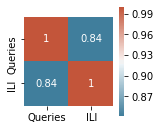

In [29]:
cmap = sns.diverging_palette(230, 20, as_cmap = True)
plt.subplots(figsize=(2,2))
sns.heatmap(Flu_Train_Subset.corr(), annot = True, cmap = cmap, square = True)

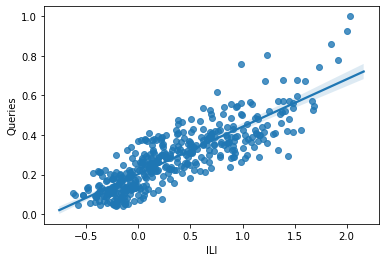

In [30]:
sns.regplot(x='ILI', y='Queries', data = Flu_Train_Subset)

In [351]:
est = sm.OLS(y, X)

In [352]:
est2 = est.fit()

In [353]:
print(est2.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.924
Model:                            OLS   Adj. R-squared (uncentered):              0.922
Method:                 Least Squares   F-statistic:                              616.4
Date:                Sat, 20 Mar 2021   Prob (F-statistic):                    3.84e-30
Time:                        18:43:07   Log-Likelihood:                         -40.203
No. Observations:                  52   AIC:                                      82.41
Df Residuals:                      51   BIC:                                      84.36
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

# Performance on the Test Set
The csv file FluTest.csv provides the 2012 weekly data of the ILI-related search queries and the observed weekly percentage of ILI-related physician visits. Load this data into a data frame called FluTest.

Normally, we would obtain test-set predictions from the model FluTrend1 using the code

PredTest1 = predict(FluTrend1, newdata=FluTest)

However, the dependent variable in our model is log(ILI), so PredTest1 would contain predictions of the log(ILI) value. We are instead interested in obtaining predictions of the ILI value. We can convert from predictions of log(ILI) to predictions of ILI via exponentiation, or the exp() function. The new code, which predicts the ILI value, is

PredTest1 = exp(predict(FluTrend1, newdata=FluTest))

What is our estimate for the percentage of ILI-related physician visits for the week of March 11, 2012?

In [40]:
Flu_Test= pd.read_csv('FluTest.csv')

In [41]:
Flu_Test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 3 columns):
Week       52 non-null object
ILI        52 non-null float64
Queries    52 non-null float64
dtypes: float64(2), object(1)
memory usage: 1.3+ KB


In [42]:
Flu_Test.head()

,Week,ILI,Queries
0,2012-01-01 - 2012-01-07,1.766707,0.593625
1,2012-01-08 - 2012-01-14,1.543401,0.499336
2,2012-01-15 - 2012-01-21,1.647615,0.500664
3,2012-01-22 - 2012-01-28,1.684297,0.479416
4,2012-01-29 - 2012-02-04,1.863542,0.471448


In [43]:
Flu_Test_Subset = Flu_Test[['Queries', 'ILI']]

In [44]:
Flu_Test_Subset .head()

,Queries,ILI
0,0.593625,1.766707
1,0.499336,1.543401
2,0.500664,1.647615
3,0.479416,1.684297
4,0.471448,1.863542


In [45]:
X = Flu_Test_Subset.iloc[:, :-1].values
y = Flu_Test_Subset.iloc[:, -1].values

In [46]:
PredTest = LinearRegression()
PredTest = FluTrend1.predict(X)

In [47]:
PredTest

array([1.25855522, 0.97933641, 0.98326907, 0.92034652, 0.89675056,
       0.99113439, 1.02259566, 0.98326907, 0.86528929, 0.85742397,
       0.78270344, 0.58607047, 0.58213782, 0.53887856, 0.58213782,
       0.47988867, 0.42483144, 0.40516814, 0.3225823 , 0.39730283,
       0.31864964, 0.27539039, 0.30685166, 0.24392911, 0.27539039,
       0.20853518, 0.24392911, 0.28718836, 0.22819847, 0.24392911,
       0.23606379, 0.24786177, 0.29898634, 0.36977421, 0.42089878,
       0.48775399, 0.56247452, 0.73944419, 0.7866361 , 0.85742397,
       0.88495258, 0.84955865, 0.84562599, 0.9321445 , 0.8928179 ,
       1.05012428, 1.01473034, 1.30574713, 1.49058212, 1.58889861,
       1.83272349, 1.88574338])

The dependent variable in our model is log(ILI), so PredTest would contain predictions of the log(ILI) value. We are instead interested in obtaining predictions of the ILI value. We can convert from predictions of log(ILI) to predictions of ILI via exponentiation, or the exp() function.

In [48]:
PredExp = np.exp(PredTest)

In [49]:
PredExp

array([3.52033171, 2.66268872, 2.67318078, 2.51016006, 2.45162375,
       2.6942891 , 2.78040239, 2.67318078, 2.37569324, 2.35708095,
       2.18737772, 1.7969135 , 1.78986074, 1.71408354, 1.78986074,
       1.6158945 , 1.52933261, 1.49955462, 1.38068852, 1.48780641,
       1.3752694 , 1.31704473, 1.35913934, 1.27625386, 1.31704473,
       1.23187226, 1.27625386, 1.33267522, 1.25633465, 1.27625386,
       1.26625508, 1.28128281, 1.3484912 , 1.44740777, 1.52333008,
       1.62865414, 1.75500994, 2.09477089, 2.19599687, 2.35708095,
       2.4228695 , 2.33861448, 2.32943556, 2.53995026, 2.44200129,
       2.85800628, 2.75861941, 3.69044531, 4.43967921, 4.89835095,
       6.2508877 , 6.59125245])

# Performance on the Test Set
We try to find what is the relative error between the estimate (our prediction) and the observed value for the week of March 11, 2012. The relative error is calculated as:

Relative Error = (Observed ILI - Estimated ILI) / Observed ILI

In [50]:
Observed_ILI = Flu_Test_Subset.iloc[10].ILI

In [51]:
Observed_ILI

2.293421558

In [52]:
Estimated_ILI = PredExp[10]

In [53]:
Estimated_ILI

2.1873777211145464

In [54]:
Relative_Error = (Observed_ILI - Estimated_ILI)/Observed_ILI

In [55]:
Relative_Error

0.04623826636474544

In [56]:
#MAE
print(metrics.mean_absolute_error(y, PredExp))

0.5944270204433815


In [57]:
#MSE
print(metrics.mean_squared_error(y, PredExp))

0.5610976657624932


In [58]:
#RMSE
print(np.sqrt(metrics.mean_squared_error(y, PredExp)))

0.7490645271019668
